In [1]:
import pickle
import os

FOLDER = os.getcwd() + "/7cells"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    psf = pickle.load(file)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np
from scipy.ndimage import gaussian_filter
from utils import *

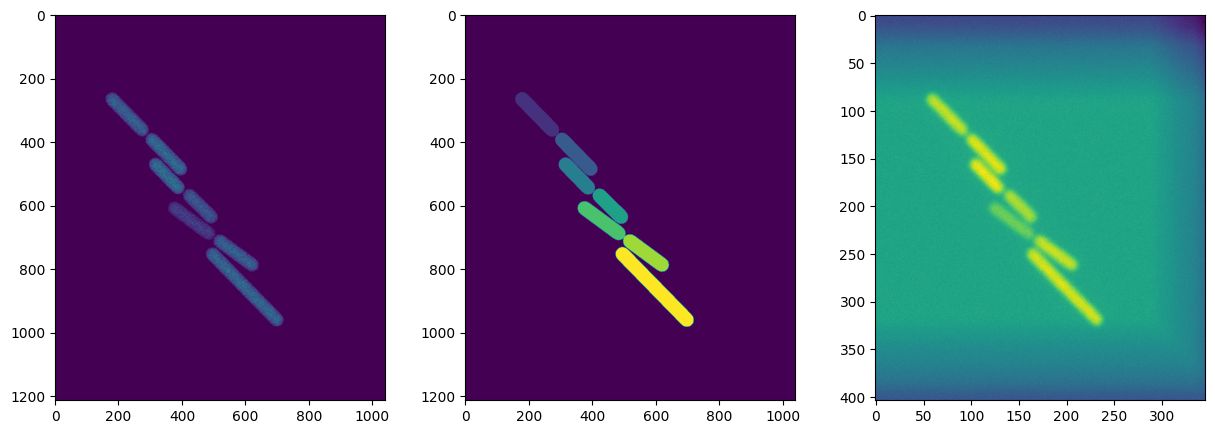

In [3]:
ori = ori/max(ori.flatten())
mask = mask/max(mask.flatten())
out = out/max(out.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

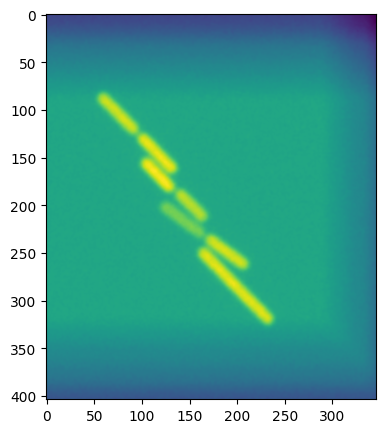

In [4]:
#Apply gaussian filter to out

outBlur = gaussian_filter(out, sigma=1)
plt.imshow(outBlur)

In [5]:
sourcePts = GetSourcePts(mask)
recoveredImage = InverseMatrix(outBlur, mask, sourcePts, learningRate = 1, psf=psf)

[0.14285715, 0.2857143, 0.42857143, 0.5714286, 0.71428573, 0.85714287, 1.0]
[[ 5.81676100e-06]
 [ 7.89524895e-06]
 [ 5.90249319e-03]
 [ 9.55514915e-02]
 [-6.09279874e-01]
 [ 6.31201695e-01]
 [ 1.00000000e+00]]


IndexError: index 346 is out of bounds for axis 1 with size 346

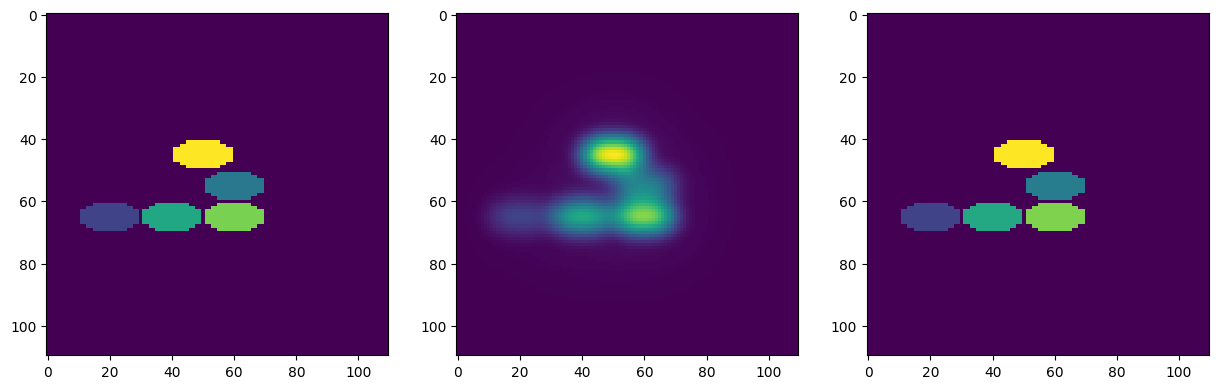

In [ ]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(out)
axarr[2].imshow(recoveredImage)
plt.show()

/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/sit

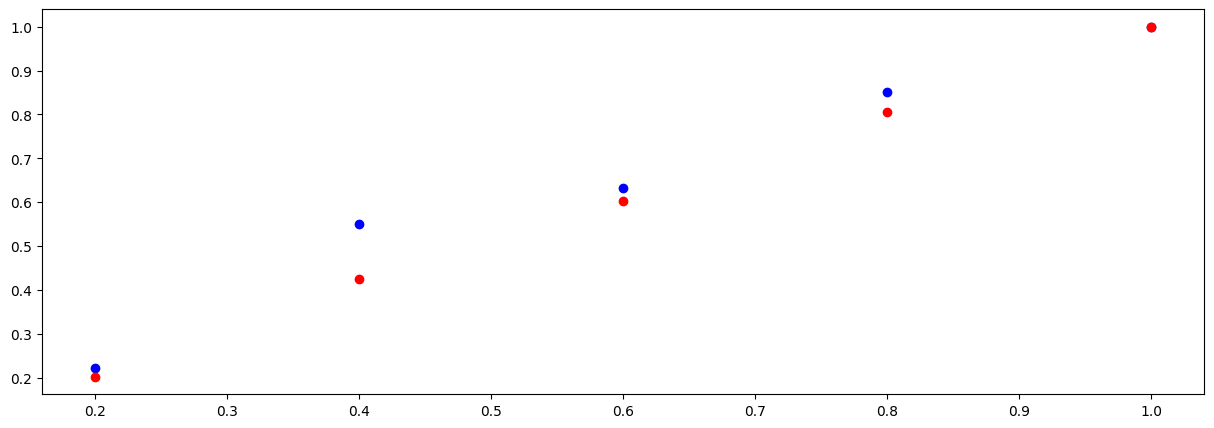

Default:  [[1.         0.98365535]
 [0.98365535 1.        ]]
Custom:  [[1.         0.99956634]
 [0.99956634 1.        ]]


In [ ]:
#Get average intensity in each mask

average_original_mask, average_original_intensity = GetAvgIntensityWithMask(ori,mask,sourcePts)
average_output_mask, average_output_intensity = GetAvgIntensityWithMask(out,mask,sourcePts)
average_custom_mask, average_custom_intensity = GetAvgIntensityWithMask(recoveredImage,mask,sourcePts)

assert(average_custom_intensity.all()==average_original_intensity.all())
assert(average_output_intensity.all()==average_original_intensity.all())

plt.plot(average_original_intensity,average_output_intensity,'bo')
plt.plot(average_original_intensity,average_custom_intensity,'ro')
plt.show()

#Calculate correlation coefficient
print("Default: ", np.corrcoef(average_original_intensity,average_output_intensity))
print("Custom: ", np.corrcoef(average_original_intensity,average_custom_intensity))